In [4]:
from tensorly.decomposition.candecomp_parafac import *
# from tensorly.decomposition import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF
from tensorly.kruskal_tensor import *

In [32]:
df_test = pd.read_csv('./PARAFAC implementation/Testing Data/combined_sensor_data_average_ok_values.csv',index_col=0)


C:\Users\Sverrir\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [33]:
df_test = df_test.loc[df_test.Name == 'K-RVK-036-RS211']

In [34]:
# df_test = pd.read_csv('./PARAFAC implementation/Testing Data/K036VRÁS-RS211.csv',index_col=0)
df_test.index = pd.DatetimeIndex(df_test.CTime)
# df_test = df_test.loc[df_test.OkPct >= 98]
# df_test = df_test.loc[df_test.Flag == 524480]


In [35]:
# x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val

In [36]:
x = df_test.loc[(df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7,24))

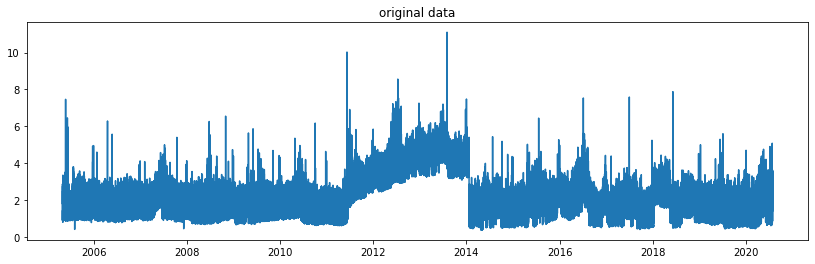

In [37]:
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('original data')
plt.show()

In [38]:
rank = 5
(core_tesnor,loadingsCustom2),errors = non_negative_parafac_custom(X.reshape(-1,24*7),
                                                            rank=rank,
                                                            n_iter_max = 10000,
                                                            tol=1e-10,  
                                                            return_errors=True, 
                                                            flat_factors = [(1,0)],
                                                            normalize_factors=False)
l_weeks,l_weekhours = loadingsCustom2

[]

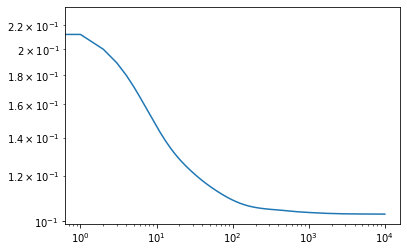

In [39]:
plt.plot(errors)
plt.loglog()

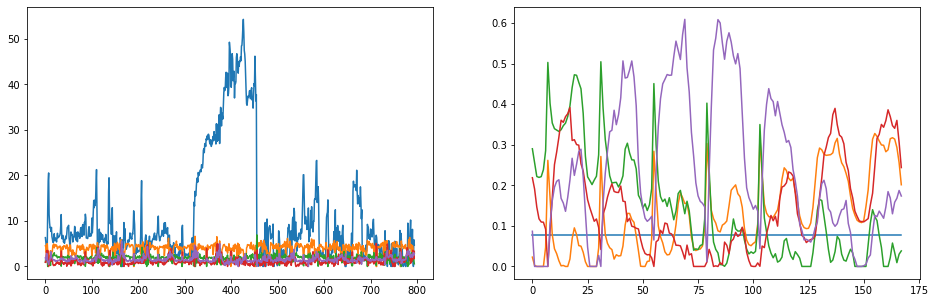

In [40]:
f,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(l_weeks)
ax[1].plot(l_weekhours)
plt.show()

In [41]:
from scipy.optimize import nnls
def predict_one_week(b,y):
    # Solve the problem of xb = y
    
    x = nnls(b,y,)
    return x[0]

predicted_abundances = predict_one_week(loadingsCustom2[1],X.reshape(-1,24*7)[10])

In [42]:
def get_strides_and_shift(array,window = 168):   
    n = array.shape[0] - window + 1
    arr_strided = np.lib.stride_tricks.as_strided(array, shape=[n, window], strides=2*array.strides)
    shifts = np.arange(0,len(arr_strided))%168
    return arr_strided,shifts

In [43]:
x_flat = X.ravel()
profile_shift_dict = {i:np.roll(loadingsCustom2[1],-i,axis=0) for i in range(168)}
X_strided,shifts = get_strides_and_shift(x_flat)

pred_stack = np.array([predict_one_week(profile_shift_dict[shifts[i]],X_strided[i]) for i in range(len(X_strided))])

In [44]:
predictions = np.zeros((len(pred_stack),168))
separate_predictions = np.zeros((rank,len(pred_stack),168))

In [45]:
for i,abundance_estimates in enumerate(pred_stack):
#     print(profile_shift_dict[i%168].shape)
    predictions[i] = abundance_estimates.reshape(1,-1)@profile_shift_dict[i%168].T
    for p,(abundance,pattern) in enumerate(zip(abundance_estimates,profile_shift_dict[i%168].T)):
        separate_predictions[p,i] = abundance*pattern

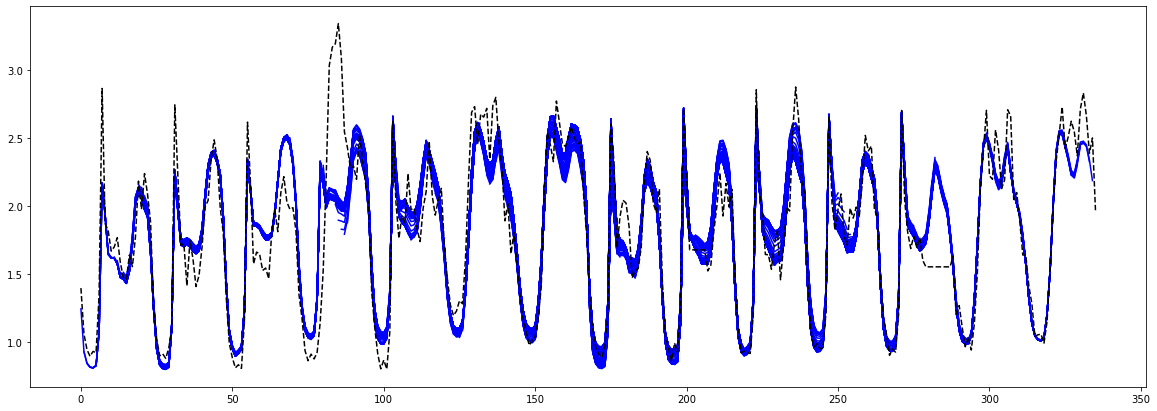

In [61]:
plt.figure(figsize=(20,7))
for i in range(168):
    plt.plot(np.arange(168)+i,predictions[i],c='blue')

plt.plot(x_flat[:168+168],c='black',linestyle='--')

In [47]:
separate_predictions.min()

0.0

In [48]:
predictions_fixed = np.zeros((len(x_flat),168))
seperate_predictions_fixed = np.zeros((rank,len(x_flat),168))
for i in range(168):
    start = i
    end = np.min([-167+i,-1])
#     print(start,end)
    if i == 167:
        predictions_fixed[start:,i] = predictions[:,i]
        for s in range(len(separate_predictions)):
            seperate_predictions_fixed[s,start:,i] = separate_predictions[s,:,i]
    else:
        for s in range(len(separate_predictions)):
            seperate_predictions_fixed[s,start:end,i] = separate_predictions[s,:,i]
        predictions_fixed[start:end,i] = predictions[:,i]
        
predictions_fixed[predictions_fixed == 0] = None
prediction_final = np.nanmean(predictions_fixed,axis=1)

separate_predictions_final = np.zeros([len(separate_predictions),len(prediction_final)])
for s in range(len(separate_predictions)):
    seperate_predictions_fixed[seperate_predictions_fixed == 0] = None
    separate_predictions_final[s] = np.nanmean(seperate_predictions_fixed[s],axis=1)

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


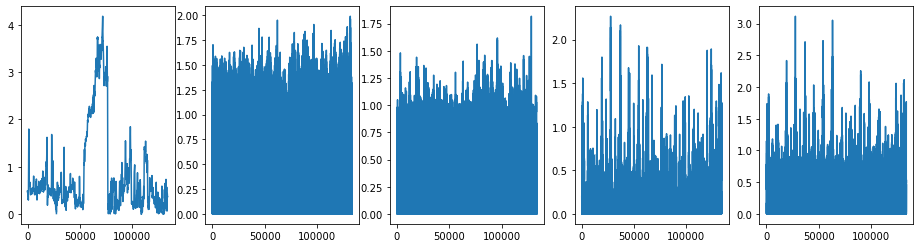

In [49]:
f,axes = plt.subplots(1,rank,figsize=(16,4))
for i,ax in enumerate(axes):
    ax.plot(separate_predictions_final.T[:,i])

In [50]:
# pd.Series(separate_predictions_final.T[:,1]).rolling(24*7).mean().plot()

In [51]:
np.mean((prediction_final-x_flat)**2)

0.06052748526754551

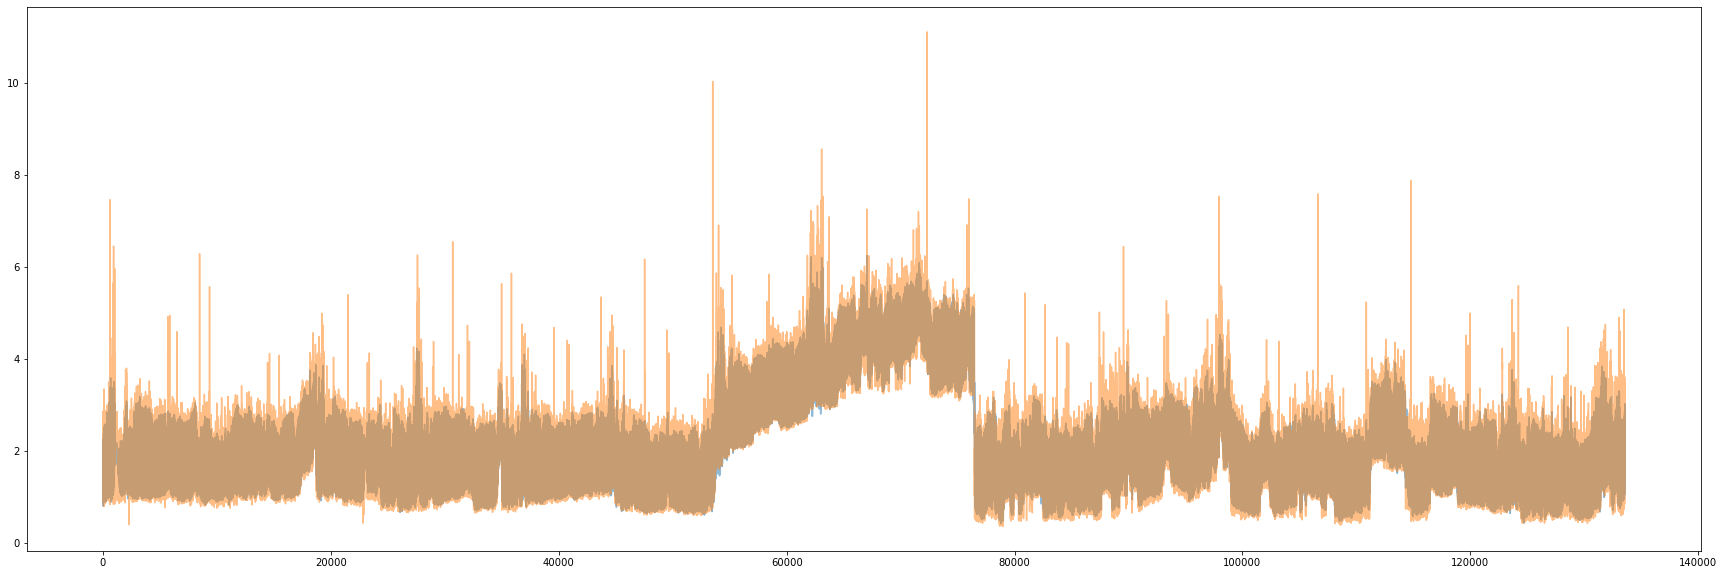

In [52]:
plt.figure(figsize=(30,10))
plt.plot(prediction_final,alpha=0.5)
plt.plot(x_flat,alpha=0.5)
plt.show()

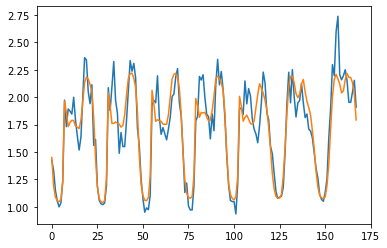

In [53]:
plt.plot(X.reshape(-1,24*7)[10])
plt.plot((predicted_abundances*loadingsCustom2[1]).sum(axis=1))

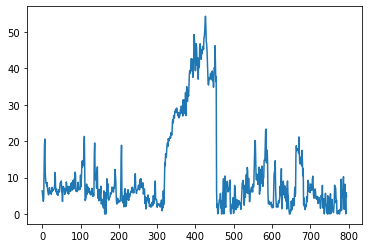

In [54]:
plt.plot(l_weeks[:,0])

In [55]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [56]:
correlation = np.correlate(l_weeks[:,2], l_weeks[:,2], mode='full')

In [57]:
l_weeks[:,2].shape

(795,)

In [58]:
np.corrcoef(l_weeks[1:,2],l_weeks[:-1,2])


array([[1.        , 0.18293452],
       [0.18293452, 1.        ]])

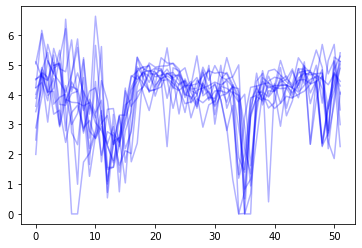

In [59]:
plt.plot(l_weeks[:(683//52)*52,1].reshape(-1,52).T,c='blue',alpha=0.3)
plt.show()

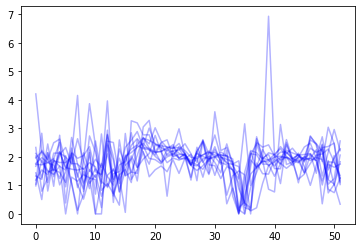

In [60]:
plt.plot(l_weeks[:(683//52)*52,2].reshape(-1,52).T,c='blue',alpha=0.3)
plt.show()

# Notable observation:

For "Skerjafjörður":


We see that once we isolate the patterns, we can see very clear annual patterns in the abundances of the patterns themselves. This could be useful later for better predictions